In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [54]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Missing values

### we have 19 features with missing values
### we have to deal with these before modeling

In [55]:
total_missing = houseprices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (houseprices_df.isnull().sum()/houseprices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


In [56]:
list(missing_data.index[:5])

['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ']

In [57]:
# dropping all columns that have more then 40% missing values
houseprices_df.drop(list(missing_data.index[:5]),axis =1, inplace=True)

In [58]:
# rechecking for missing data
houseprices_df.isnull().sum().sort_values(ascending=False).head(14)

lotfrontage     259
garagefinish     81
garagetype       81
garagecond       81
garagequal       81
garageyrblt      81
bsmtexposure     38
bsmtfintype2     38
bsmtfintype1     37
bsmtcond         37
bsmtqual         37
masvnrtype        8
masvnrarea        8
electrical        1
dtype: int64

In [59]:
# checking for all missing values with gaaragefinish as it seems that all garage things have same valuies missing
houseprices_df.loc[houseprices_df['garagefinish'].isnull(), :].isnull().sum().sort_values(ascending = False)[:10]

garagetype      81
garageyrblt     81
garagefinish    81
garagecond      81
garagequal      81
bsmtfintype1     7
bsmtexposure     7
lotfrontage      7
bsmtcond         7
bsmtqual         7
dtype: int64

In [60]:
# notice all 81 of rows which have garage type also have other garage values missing
houseprices_df = houseprices_df.dropna(subset=['garagefinish'], how = 'any')

In [61]:
# rechecking for missing data seems lie we have the same issue with bsmtfintype
houseprices_df.isnull().sum().sort_values(ascending=False)[:10]

lotfrontage     252
bsmtfintype2     31
bsmtexposure     31
bsmtqual         30
bsmtfintype1     30
bsmtcond         30
masvnrarea        8
masvnrtype        8
electrical        1
roofmatl          0
dtype: int64

In [62]:
# notice all 30 of rows which have bsmt type also have other bsmt values missing
houseprices_df.loc[houseprices_df['bsmtfintype2'].isnull(), :].isnull().sum().sort_values(ascending = False)[:10]

bsmtfintype2    31
bsmtqual        30
bsmtfintype1    30
bsmtexposure    30
bsmtcond        30
lotfrontage      6
exterqual        0
roofmatl         0
exterior1st      0
exterior2nd      0
dtype: int64

In [63]:
# just like garage basement feature rows have the same rows with missing values, so we drop them
houseprices_df = houseprices_df.dropna(subset=['bsmtfintype2'], how = 'any')

In [64]:
houseprices_df.isnull().sum().sort_values(ascending=False)[:5]

lotfrontage     246
masvnrtype        8
masvnrarea        8
electrical        1
bsmtexposure      1
dtype: int64

In [65]:
# dropping one row of basement exposure
houseprices_df = houseprices_df.dropna(subset=['bsmtexposure','electrical'], how = 'any')
houseprices_df.isnull().sum().sort_values(ascending=False)[:3]

lotfrontage    246
masvnrtype       8
masvnrarea       8
dtype: int64

In [66]:
houseprices_df.groupby('neighborhood')['lotfrontage'].mean()

neighborhood
Blmngtn    47.142857
Blueste    24.000000
BrDale     21.600000
BrkSide    58.761905
ClearCr    78.818182
CollgCr    71.926829
Crawfor    71.804878
Edwards    70.476923
Gilbert    79.877551
IDOTRR     60.925926
MeadowV    31.200000
Mitchel    67.700000
NAmes      77.369942
NPkVill    32.285714
NWAmes     81.288889
NoRidge    91.878788
NridgHt    81.840000
OldTown    62.875000
SWISU      59.210526
Sawyer     75.159091
SawyerW    72.444444
Somerst    64.666667
StoneBr    62.700000
Timber     80.379310
Veenker    59.714286
Name: lotfrontage, dtype: float64

In [67]:
# filling missing values based on neighborhood
houseprices_df["lotfrontage"] = houseprices_df.groupby("neighborhood").transform(lambda x: x.fillna(x.mean()))

In [68]:
# filling missing values based on neighborhood
houseprices_df["masvnrtype"] = houseprices_df.groupby("neighborhood").transform(lambda x: x.fillna(x.mean()))

In [69]:
# filling missing values based on neighborhood
houseprices_df["masvnrarea"] = houseprices_df.groupby("neighborhood").transform(lambda x: x.fillna(x.mean()))

In [70]:
# checking for missing value again and we discover we have none left
houseprices_df.isnull().sum().sort_values(ascending=False)[:3]

saleprice    0
extercond    0
roofstyle    0
dtype: int64

## EDA AND FEATURE SELECTION

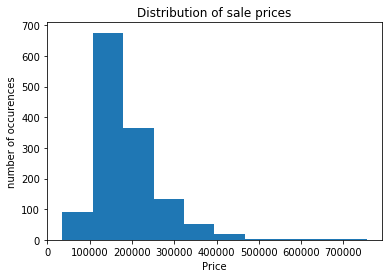

In [71]:
# checking for distribution
plt.hist(houseprices_df.saleprice)
plt.title("Distribution of sale prices")
plt.xlabel("Price")
plt.ylabel("number of occurences")
plt.show()

## prices are higly skewed, with most houses selling between 100,000 and 200,000

In [72]:
# sorting numeric and non numeric data
non_numeric = houseprices_df.select_dtypes(['object']).columns
numeric = houseprices_df.select_dtypes(['int64','float']).columns

print(non_numeric)
print("The number of non-numerical columns is {}".format(len(non_numeric)))
print(numeric)
print("The number of numerical columns is {}".format(len(numeric)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating',
       'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional',
       'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 37
Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrtype', 'masvnrarea',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf',
       'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
  

In [73]:
## we can run a correlation for numeric columns without the id column and only select sale price column
np.abs(houseprices_df[numeric].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.784596
grlivarea        0.710017
garagecars       0.641109
garagearea       0.608736
firstflrsf       0.603505
totalbsmtsf      0.602612
fullbath         0.567029
totrmsabvgrd     0.548900
yearbuilt        0.504132
yearremodadd     0.501153
garageyrblt      0.481825
fireplaces       0.443355
bsmtfinsf1       0.362246
openporchsf      0.327406
secondflrsf      0.307796
wooddecksf       0.305896
halfbath         0.260352
lotarea          0.253854
bsmtfullbath     0.211808
bsmtunfsf        0.190390
bedroomabvgr     0.165177
enclosedporch    0.127199
overallcond      0.109916
kitchenabvgr     0.109509
screenporch      0.095076
poolarea         0.091166
mssubclass       0.081120
mosold           0.042637
threessnporch    0.041510
bsmtfinsf2       0.032170
bsmthalfbath     0.030957
masvnrarea       0.026857
masvnrtype       0.026857
lotfrontage      0.026857
yrsold           0.023478
miscval          0.017222
lowqualfinsf     0.010330
Name: salepr

### To understand the univariate relation between our target variable and non-numerical features; we plot each feature against the target variable. In the charts below, we show the average sale prices with respect to the each categories of a feature.

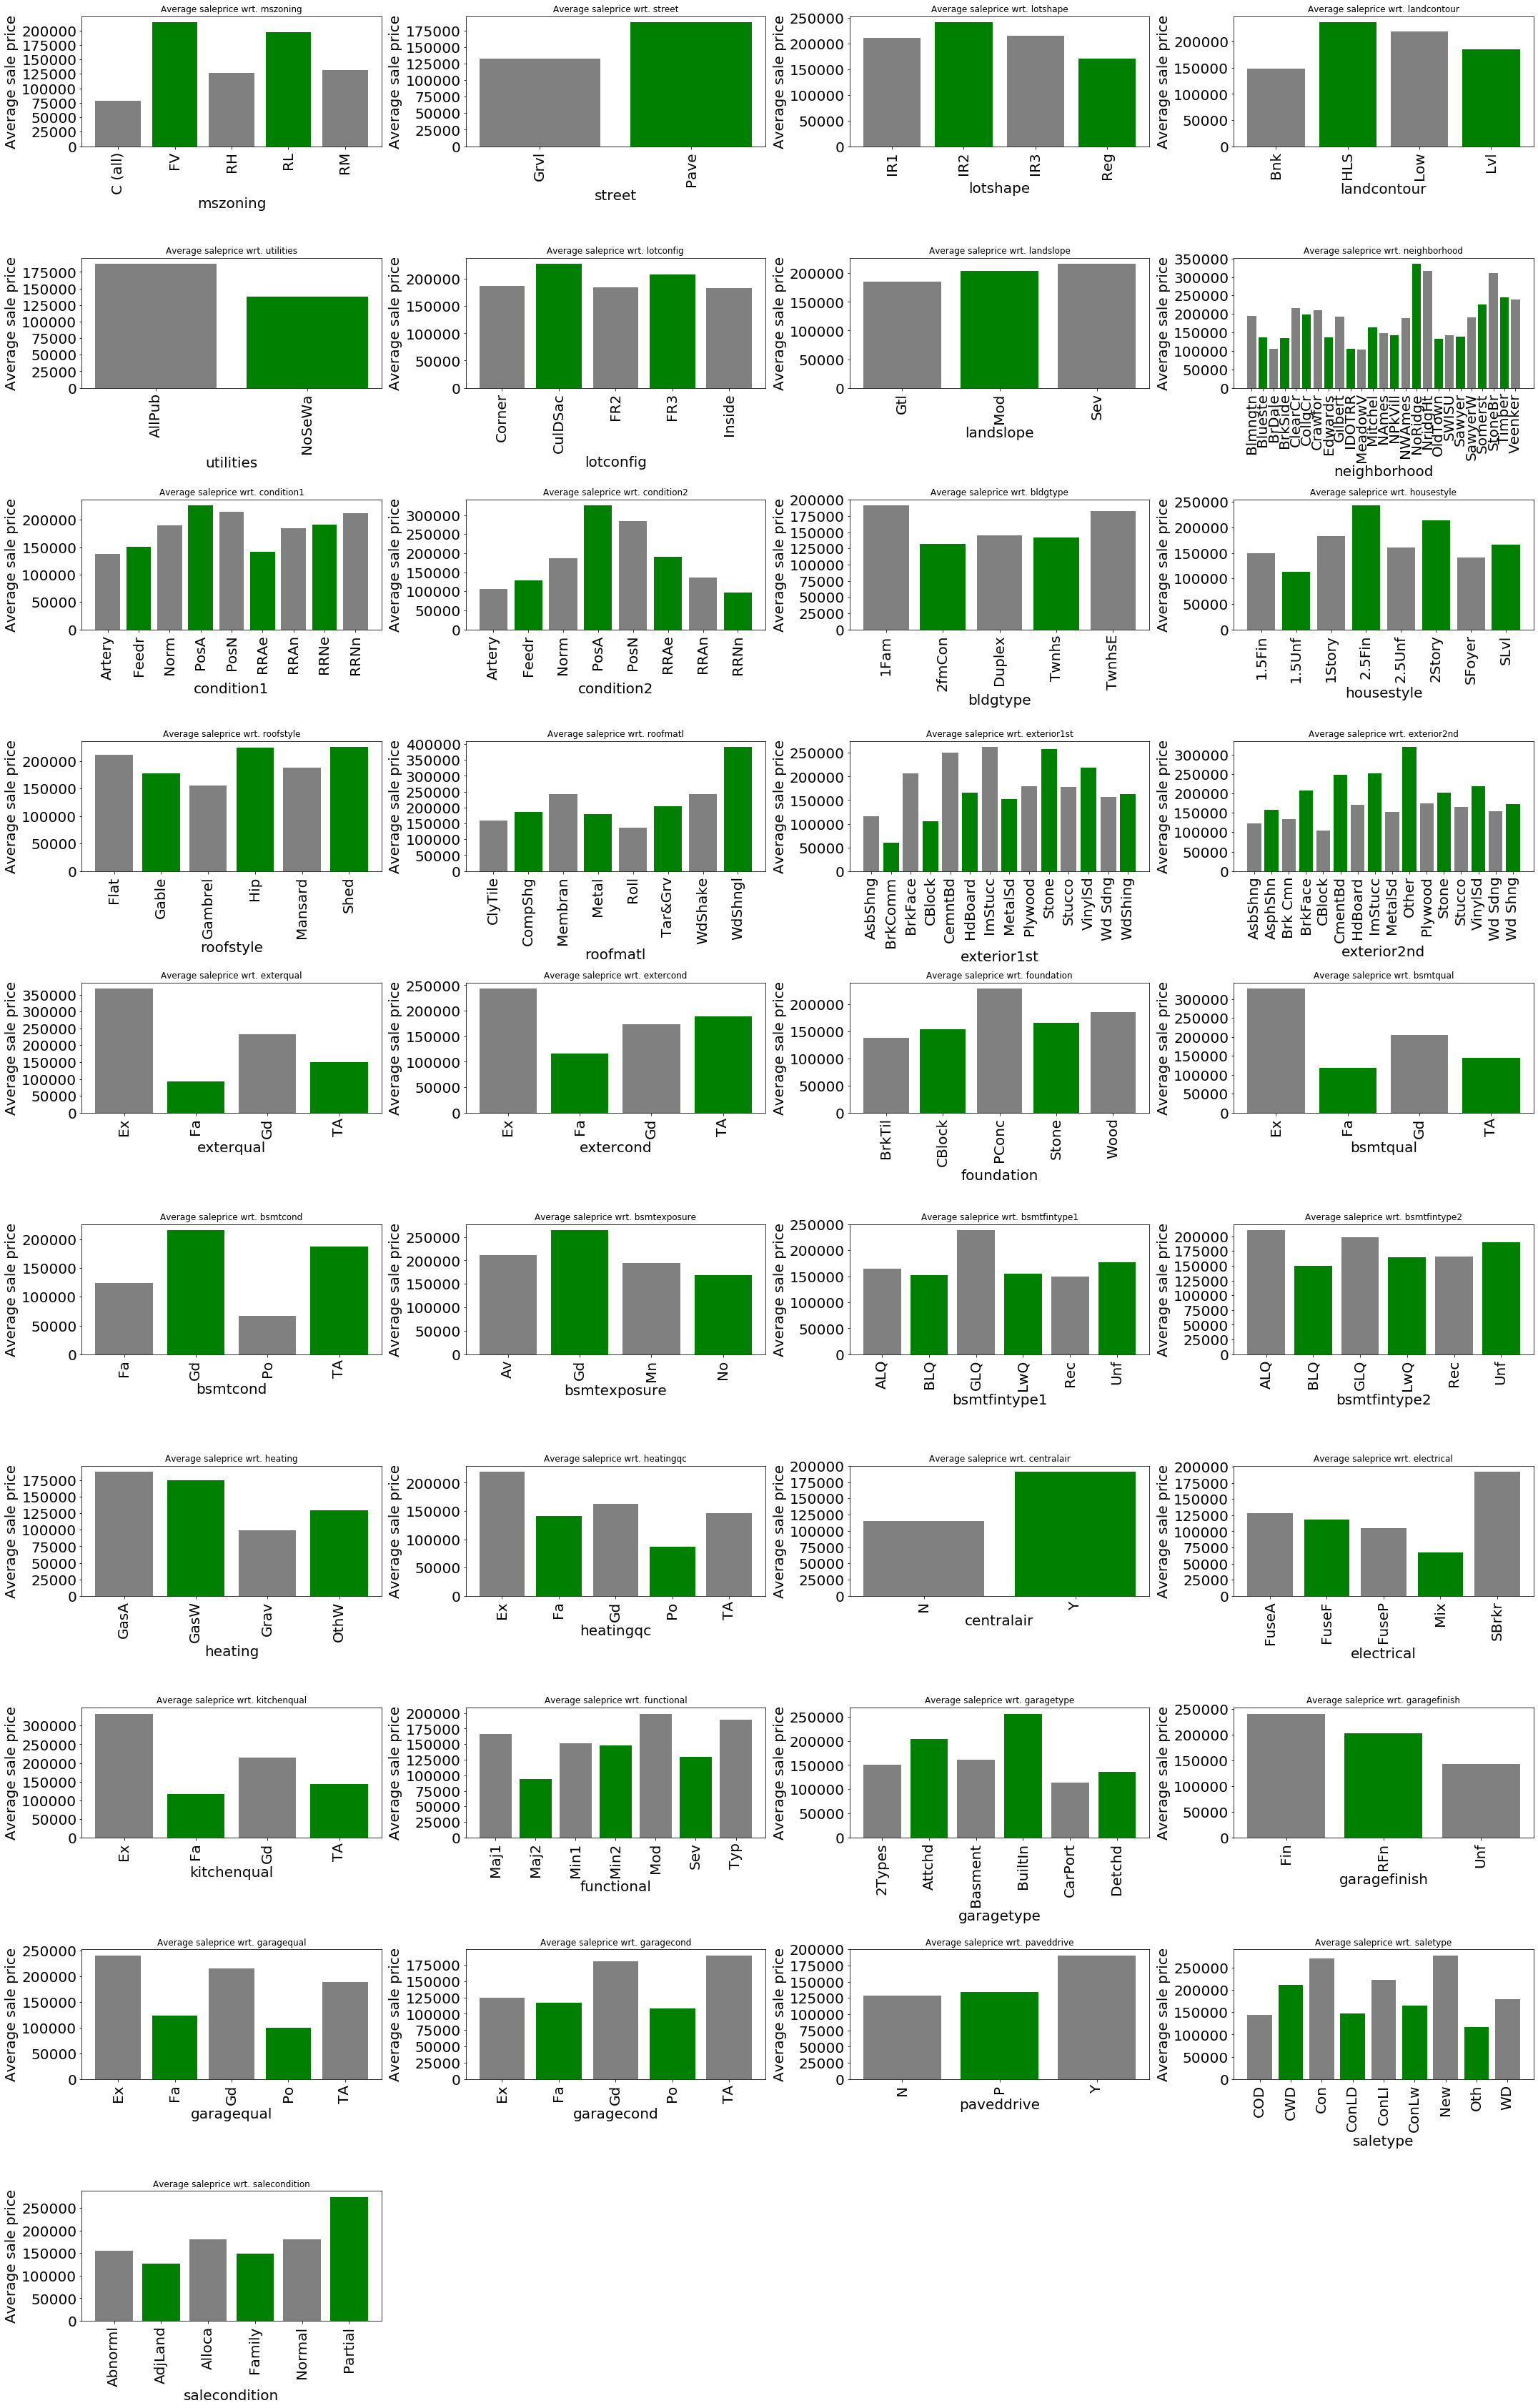

In [74]:
plt.figure(figsize=(30,50))
for index, column in enumerate(non_numeric):
    plt.subplot(11,4,index+1)
    plt.bar(houseprices_df.groupby(column)["saleprice"].mean().index, houseprices_df.groupby(column)["saleprice"].mean(),color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price", fontsize = 20)
    plt.xlabel(column, fontsize= 20)
    plt.xticks(rotation='vertical', fontsize=20)
    plt.yticks(rotation=0, fontsize=20)

plt.tight_layout()
plt.show()

## Using 6 numeric values and 4 non numeric, street and centralair, as thier values exhibit variance

## converting non numeric to dummies

In [75]:
houseprices_df=pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street",drop_first=True)],axis=1)
houseprices_df=pd.concat([houseprices_df,pd.get_dummies(houseprices_df.centralair, prefix="centralair",drop_first=True)],axis=1)
houseprices_df=pd.concat([houseprices_df,pd.get_dummies(houseprices_df.utilities, prefix="utilities",drop_first=True)],axis=1)
houseprices_df=pd.concat([houseprices_df,pd.get_dummies(houseprices_df.fireplaces,prefix="fireplaces",drop_first=True)],axis=1)
# Discovered multicorrelation so keeping only central air and fireplaces
dummy_column_names = list(pd.get_dummies(houseprices_df.centralair, prefix="centralair",drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.fireplaces, prefix="fireplaces",drop_first=True).columns)

In [76]:
houseprices_df.head(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,yrsold,saletype,salecondition,saleprice,street_Pave,centralair_Y,utilities_NoSeWa,fireplaces_1,fireplaces_2,fireplaces_3
0,1,60,RL,1.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,2008,WD,Normal,208500,1,1,0,0,0,0
1,2,20,RL,2.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,2007,WD,Normal,181500,1,1,0,1,0,0


## REGRESSION MODEL

In [77]:
X = houseprices_df[['overallqual', 'grlivarea', 'firstflrsf', 'garagearea', 'totalbsmtsf','yearbuilt'] + dummy_column_names]
Y = houseprices_df.saleprice

In [78]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     452.4
Date:                Wed, 18 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:06:19   Log-Likelihood:                -16094.
No. Observations:                1346   AIC:                         3.221e+04
Df Residuals:                    1335   BIC:                         3.227e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.109e+05   9.29e+04     -7.654      0.000   -8.93e+05   -5.29e+05
overallqual    2.18e+04   1235.229     17.649      0.000    1.94e+04    2.42e+04
grlivarea       47.6475      2.917     16.336      0.000      41.926      53.369
firstflrsf       5.4314      6.631      0.819      0.413      -7.577      18.440
garagearea      53.1397      7.303      7.277      0.000      38.814      67.466
totalbsmtsf     24.6065      6.227      3.952      0.000      12.391      36.822
yearbuilt      311.3078     49.492      6.290      0.000     214.217     408.399
centralair_Y  1.022e+04   5382.703      1.898      0.058    -342.472    2.08e+04
fireplaces_1  5752.2268   2468.564      2.330      0.020     909.540    1.06e+04
fireplaces_2  2.857e+04   4282.889      6.671      0.000    2.02e+04     3.7e+04
fireplaces_3 -7.886e+04   1.77e+04     -4.452      0.000   -1.14e+05   -4.41e+04
==============================================================================
Omnibus:                      366.059   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28183.256
Skew:                          -0.151   Prob(JB):                         0.00
Kurtosis:                      25.415   Cond. No.                     2.75e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
#Re-estimating without 'firstflrsf' after we determined its statisically insignificant.
X = houseprices_df[['overallqual', 'grlivarea', 'garagearea', 'totalbsmtsf','yearbuilt'] + dummy_column_names]
Y = houseprices_df.saleprice
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     502.7
Date:                Wed, 18 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:06:19   Log-Likelihood:                -16095.
No. Observations:                1346   AIC:                         3.221e+04
Df Residuals:                    1336   BIC:                         3.226e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.947e+05   9.07e+04     -7.656      0.000   -8.73e+05   -5.17e+05
overallqual   2.176e+04   1234.195     17.633      0.000    1.93e+04    2.42e+04
grlivarea       48.2632      2.818     17.128      0.000      42.735      53.791
garagearea      53.6341      7.277      7.371      0.000      39.359      67.909
totalbsmtsf     28.9382      3.287      8.804      0.000      22.490      35.386
yearbuilt      303.2575     48.501      6.253      0.000     208.112     398.403
centralair_Y  1.043e+04   5375.728      1.940      0.053    -115.325     2.1e+04
fireplaces_1  6051.8055   2441.016      2.479      0.013    1263.163    1.08e+04
fireplaces_2  2.897e+04   4254.987      6.807      0.000    2.06e+04    3.73e+04
fireplaces_3  -7.91e+04   1.77e+04     -4.467      0.000   -1.14e+05   -4.44e+04
==============================================================================
Omnibus:                      371.712   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29334.444
Skew:                          -0.189   Prob(JB):                         0.00
Kurtosis:                      25.867   Cond. No.                     2.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared and adjusted R-squared of the model are 0.772 and 0.770 respectively.
F statistic and its associated p-value are 502.7 and 0.00 respectively.
AIC and BIC of the model are 32210 and 32260 respectively.
According to the R-squared almost 77% of the variance in the target variable is explained by the model. Hence 23% of the variance in the target is not explained. In this sense, there is a large room for improvement.

### In order to increase the goodness of fit of our model:

### We first log transform the dependent variable. The saleprice variable is not normally distributed, so log transforming may help in this regard. To this end, we apply log(1+x) transformation of NumPy.

### Second, we create another variable by summing up the basement, first and the second floor areas.

### Third, we add the interaction of the total area and the overall quality of the house.

In [80]:
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']

houseprices_df['int_over_sf'] = houseprices_df['totalsf'] * houseprices_df['overallqual']

Y = np.log1p(houseprices_df['saleprice'])

X = houseprices_df[['overallqual', 'grlivarea', 'garagearea','yearbuilt', 'totalsf', 'int_over_sf'] + dummy_column_names]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     615.4
Date:                Wed, 18 Sep 2019   Prob (F-statistic):               0.00
Time:                        18:06:19   Log-Likelihood:                 564.62
No. Observations:                1346   AIC:                            -1107.
Df Residuals:                    1335   BIC:                            -1050.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.0413      0.384     15.727      0.000       5.288       6.795
overallqual      0.1580      0.010     15.876      0.000       0.138       0.178
grlivarea        0.0001   1.94e-05      5.736      0.000    7.31e-05       0.000
garagearea       0.0002   3.07e-05      8.085      0.000       0.000       0.000
yearbuilt        0.0021      0.000     10.425      0.000       0.002       0.003
totalsf          0.0003   2.82e-05      9.352      0.000       0.000       0.000
int_over_sf  -2.143e-05   3.15e-06     -6.802      0.000   -2.76e-05   -1.52e-05
centralair_Y     0.1496      0.023      6.594      0.000       0.105       0.194
fireplaces_1     0.0539      0.010      5.181      0.000       0.033       0.074
fireplaces_2     0.1418      0.018      7.866      0.000       0.106       0.177
fireplaces_3    -0.2062      0.076     -2.725      0.007      -0.355      -0.058
==============================================================================
Omnibus:                      469.667   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4816.155
Skew:                          -1.317   Prob(JB):                         0.00
Kurtosis:                      11.885   Cond. No.                     1.72e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### R-squared and adjusted R-squared of the model are 0.822 and 0.820 respectively. These are improvements upon the first model.
### F statistic and its associated p-value are 559.1 and 0.00 respectively. This also indicates that the second model is better than the first one.
### AIC and BIC of the model are -1105 and -1043 respectively. These values are lower than the ones of the first model. Hence, the second model is better than the first model.

### Considering all of the metrics above, our second model has a better goodness of fit than the first model.

In [81]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1076
The number of observations in test set is 270


In [119]:
# Using sklearn instead of OLS
model = LinearRegression()
model.fit(X_train, y_train)
print("Training set score:", model.score(X_train, y_train))
print("Testing set score:", model.score(X_test, y_test))

Training set score: 0.8297676394168476
Testing set score: 0.43980360218447295


In [86]:
# Looking at cross validation with 5 folds
print(cross_val_score(model, X_train, y_train, cv = 5))
print(cross_val_score(model, X_train, y_train, cv = 5).mean())

[0.81927876 0.85525595 0.77882278 0.81786562 0.84707806]
0.8236602346308703


In [87]:
# Inspect coefficients
dict(zip(X.columns, model.coef_))

{'const': 0.0,
 'overallqual': 0.1148784335652644,
 'grlivarea': 0.00010859919251935074,
 'garagearea': 0.0002272543398460121,
 'yearbuilt': 0.0021748009978096324,
 'totalsf': 0.00018306184713022468,
 'int_over_sf': -6.612064191988121e-06,
 'centralair_Y': 0.1524464113861395,
 'fireplaces_1': 0.04201394664291396,
 'fireplaces_2': 0.12382603802830304,
 'fireplaces_3': 0.13351367409587678}

In [88]:
X.head()

,const,overallqual,grlivarea,garagearea,yearbuilt,totalsf,int_over_sf,centralair_Y,fireplaces_1,fireplaces_2,fireplaces_3
0,1.0,7,1710,548,2003,2566,17962,1,0,0,0
1,1.0,6,1262,460,1976,2524,15144,1,1,0,0
2,1.0,7,1786,608,2001,2706,18942,1,1,0,0
3,1.0,7,1717,642,1915,2473,17311,1,1,0,0
4,1.0,8,2198,836,2000,3343,26744,1,1,0,0


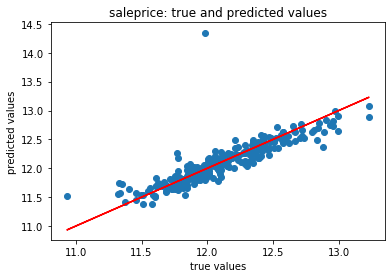

Mean absolute error of the prediction is: 0.11378959683454203
Mean squared error of the prediction is: 0.03972152429752887
Root mean squared error of the prediction is: 0.19930259480882045
Mean absolute percentage error of the prediction is: 0.9413600753113668


In [90]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("saleprice: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [132]:
X = X
y = np.log1p(houseprices_df['saleprice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [133]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8335253299603769
-----Test set statistics-----
R-squared of the model in test set is: 0.7184995605692024
Mean absolute error of the prediction is: 0.11378959683434475
Mean squared error of the prediction is: 0.03972152429753295
Root mean squared error of the prediction is: 0.1993025948088307
Mean absolute percentage error of the prediction is: 0.9413600753098427


### Lasso Model Example

In [124]:
model = LassoCV(alphas=alphas, cv=5)

model.fit(X_train, y_train)

# We are making predictions here
y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)

In [125]:
print("Best alpha value is: {}".format(model.alpha_))
print("R-squared of the model in training set is: {}".format(model.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(model.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.833525088036877
-----Test set statistics-----
R-squared of the model in test set is: 0.7187316394270364
Mean absolute error of the prediction is: 0.11378660012490387
Mean squared error of the prediction is: 0.03968877647657381
Root mean squared error of the prediction is: 0.19922042183615066
Mean absolute percentage error of the prediction is: 0.9413352106081416


### First Ridge model

In [129]:
ridgeregr = RidgeCV(alphas=alphas, cv=5)
ridgeregr.fit(X_train, y_train)
# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

In [130]:
print("Best alpha value is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model on the training set is: 0.8335008437898941
-----Test set statistics-----
R-squared of the model on the test set is: 0.7207708612942345
Mean absolute error of the prediction is: 0.11374906622865098
Mean squared error of the prediction is: 0.03940102914264512
Root mean squared error of the prediction is: 0.1984969247687357
Mean absolute percentage error of the prediction is: 0.9410251899688735


### Try ElasticNet here

In [131]:
elasticregr = ElasticNetCV(alphas=alphas, cv=5)
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("Best alpha value is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model on the training set is: 0.8335252528183119
-----Test set statistics-----
R-squared of the model on the test set is: 0.7186319011225284
Mean absolute error of the prediction is: 0.11378778587660233
Mean squared error of the prediction is: 0.03970285019345298
Root mean squared error of the prediction is: 0.19925574067878943
Mean absolute percentage error of the prediction is: 0.9413450618374816
